# Fama and French Factor Model #

### Import Data ###

In [4]:
# Import Libraries

# Data Management
import pandas as pd
import numpy as np

# Plots
import matplotlib.pyplot as plt

# Statistics
import statsmodels.api as sm

# Manipulate Files
import os

# Pretty Notation
from IPython.display import display, Math

In [5]:
# Get the important data for the Risk Free Rate

rfr = pd.read_csv(r"..\additional_data\rfr.csv")
rfr = rfr.set_index('Date')
rfr.index = pd.to_datetime(rfr.index, dayfirst=True)

# Get the important data for the S&P500

sp500 = pd.read_csv(r"..\additional_data\sp500.csv")
sp500 = sp500.set_index('Date')
sp500.index = pd.to_datetime(sp500.index)

# Get the data for the Stocks' Betas

betas_df = pd.read_csv(r"..\additional_data\betas.csv")
betas_df = betas_df.set_index('Date')
betas_df.index = pd.to_datetime(betas_df.index)

In [6]:
# Create the Weights function
def wexp(N, half_life):
    c = np.log(0.5)/half_life
    n = np.array(range(N))
    w = np.exp(c*n)
    return np.flip(w/np.sum(w))

# Create the CAPM 
def CAPM(
    stock_prices: pd.Series, 
    benchmark_prices: pd.Series = sp500['sp_500'], 
    risk_free_rate: pd.Series = rfr['risk_free_rate'], 
    window: int = 252,
    WLS: bool = True,
):

    # Align time series to the same date range
    common_index = stock_prices.index.intersection(benchmark_prices.index).intersection(risk_free_rate.index)
    stock_prices = stock_prices.loc[common_index]
    benchmark_prices = benchmark_prices.loc[common_index]
    risk_free_rate = risk_free_rate.loc[common_index]
    
    # Compute daily returns
    stock_returns = stock_prices.pct_change(1)
    benchmark_returns = benchmark_prices.pct_change(1)
    risk_free_daily = (((1 + (risk_free_rate.div(100)))**(1/360)) - 1)  # Convert annual rate to daily
    
    # Excess returns
    excess_stock = stock_returns - risk_free_daily
    excess_benchmark = benchmark_returns - risk_free_daily

    alphas, betas = [], []

    # Create weights with exponential decay
    weights = window * wexp(window, window/2)
    
    for t in range(window, len(stock_returns)):
        X = excess_benchmark.iloc[t-window:t]
        y = excess_stock.iloc[t-window:t]
        
        if X.isnull().any() or y.isnull().any():
            continue

        if WLS:
            
            # Fit WLS regression
            model = sm.WLS(y, sm.add_constant(X), weights=weights, missing='drop').fit()

        else:

            # Fit OLS regression
            model = sm.OLS(y, sm.add_constant(X), missing='drop').fit()

        # Avoid KeyError by checking if params exist
        params = model.params
        
        alphas.append(params.iloc[0])
        betas.append(params.iloc[1])
            
    parameters = pd.DataFrame({
        'alpha': alphas,
        'beta': betas,
    }, index=stock_returns.index[window+1:])
    
    return parameters

In [7]:
# Folder Path
folder_path = r"..\stocks"

# Dictionary to store the DataFrames
dataframes = {}

# List all files in the folder
for file in os.listdir(folder_path):
    if file.endswith(".csv"):
        # Full path to the file
        file_path = os.path.join(folder_path, file)
        
        # Read the Excel file
        df = pd.read_csv(file_path)
        df = df.set_index("Date")
        df.index = pd.to_datetime(df.index)

        df = df[['Adjusted_close', 'Market_cap_calculado', 'Price_to_Book']]

        df = df.rename(columns={
            'Adjusted_close':'adj_close',
            'Market_cap_calculado':'market_cap',
            'Price_to_Book':'price_to_book',
        })

        # Fill nans
        df['adj_close'] = df['adj_close'].interpolate(method='linear')
        df['market_cap'] = df['market_cap'].interpolate(method='linear')
        df['price_to_book'] = df['price_to_book'].interpolate(method='linear')

        df = df.loc['2015-01-01':]

        df.dropna(inplace=True)
        
        if len(df) >= 2000:
            # File name without extension
            file_name = os.path.splitext(file)[0]
            
            # Guardar en el diccionario
            dataframes[file_name] = df
            print(f"File loaded: {file_name} ({len(df)} rows)")
        else:
            print(f"File skipped (less than 2000 rows after cleaning): {file}")

print(f"\nTotal files loaded: {len(dataframes)}")
print("Files loaded:", list(dataframes.keys()))

File loaded: A (2472 rows)
File loaded: AAPL (2472 rows)
File loaded: ABBV (2472 rows)
File skipped (less than 2000 rows after cleaning): ABNB.csv
File loaded: ABT (2472 rows)
File loaded: ADBE (2472 rows)
File loaded: ADI (2472 rows)
File loaded: ADM (2472 rows)
File loaded: ADP (2472 rows)
File loaded: ADSK (2472 rows)
File loaded: AEE (2472 rows)
File loaded: AEP (2472 rows)
File loaded: AES (2472 rows)
File loaded: AFL (2472 rows)
File loaded: AIG (2472 rows)
File loaded: AIZ (2472 rows)
File loaded: AJG (2472 rows)
File loaded: AKAM (2472 rows)
File loaded: ALB (2472 rows)
File loaded: ALGN (2472 rows)
File loaded: ALL (2472 rows)
File loaded: AMAT (2472 rows)
File loaded: AMD (2472 rows)
File loaded: AME (2472 rows)
File loaded: AMGN (2472 rows)
File loaded: AMP (2472 rows)
File loaded: AMT (2472 rows)
File loaded: AMZN (2472 rows)
File loaded: ANET (2472 rows)
File loaded: ANSS (2472 rows)
File loaded: AOS (2472 rows)
File loaded: APA (2472 rows)
File loaded: APD (2472 rows)
Fil

In [8]:
# Create a whole new dataframe that contains all the stocks betas

rets_series = []

for stock, df in dataframes.items():
    series = df['adj_close'].pct_change(1).rename(stock)  
    series = series.iloc[1:]
    rets_series.append(series)

# Concat
returns_df = pd.concat(rets_series, axis=1)
returns_df = returns_df.apply(lambda x: x.fillna(x.mean()), axis=0)
# returns_df = returns_df.sub(rfr['risk_free_rate'].dropna(), axis=0)

returns_df.dropna(inplace = True)

returns_df

,A,AAPL,ABBV,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WST,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-05,-0.018738,-0.028172,-0.018819,0.000223,-0.004976,-0.018275,-0.034602,-0.000720,-0.014614,-0.010002,...,-0.013804,0.000000,-0.017020,-0.011351,-0.027362,-0.062237,-0.020318,0.037303,-0.014077,-0.006003
2015-01-06,-0.015578,0.000094,-0.004950,-0.011356,-0.020144,-0.023384,-0.019713,-0.008350,-0.019775,-0.011641,...,-0.017107,-0.001108,-0.021331,0.005321,-0.005316,-0.005881,-0.012274,-0.008477,-0.007205,-0.009756
2015-01-07,0.013272,0.014022,0.040417,0.008108,0.008223,0.010516,0.015031,0.008784,-0.002087,0.007778,...,0.016218,0.003050,0.029368,0.008635,0.010133,0.007887,0.033138,0.024870,0.025465,0.020643
2015-01-08,0.029975,0.038422,0.010459,0.020554,0.025383,0.017655,-0.014609,0.022940,0.024747,0.003528,...,0.019657,0.010779,0.012031,0.011599,0.016645,0.007546,0.017420,0.010617,0.021359,0.015399
2015-01-09,-0.007337,0.001072,-0.027355,-0.010508,-0.014743,-0.000730,-0.008530,-0.007162,-0.009014,-0.011206,...,-0.011453,-0.001367,0.012499,-0.012285,-0.001410,-0.018863,-0.001767,-0.014424,0.014613,0.001584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-22,-0.024130,-0.002622,0.011901,-0.007437,-0.009242,-0.004653,-0.007839,0.001478,-0.004486,-0.005327,...,-0.002959,-0.019820,0.010471,0.003941,0.005163,-0.008678,-0.004776,-0.008935,-0.001584,0.000317
2024-10-23,-0.003222,-0.021623,-0.004662,0.007664,-0.016386,0.009928,0.007003,-0.004462,-0.007574,0.016408,...,0.000140,0.006319,-0.017304,0.010050,-0.003563,0.002664,0.004949,0.004220,-0.010511,-0.002744
2024-10-24,-0.017590,-0.000823,0.009421,-0.004017,-0.004453,0.012475,0.007489,-0.002103,-0.001834,-0.002130,...,0.154343,0.008791,0.002252,0.012282,-0.005654,-0.008123,-0.006417,-0.006686,-0.016409,-0.039632


In [9]:
# Create a whole new dataframe that contains all the stocks betas

mktcap_series = []

for stock, df in dataframes.items():
    series = df['market_cap'].rename(stock)  
    series = series.iloc[1:]
    mktcap_series.append(series)

# Concat
mktcap_df = pd.concat(mktcap_series, axis=1)
mktcap_df = mktcap_df.apply(lambda x: x.fillna(x.mean()), axis=0)

# Drop nans
mktcap_df.dropna(inplace = True)

# Apply Logs and EMA (maybe)
mktcap_df = np.log(mktcap_df)
mktcap_df = mktcap_df.ewm(span=5, adjust = False).mean()
mktcap_df

,A,AAPL,ABBV,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WST,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-05,23.310518,27.158261,25.354579,24.963717,24.303701,23.554108,24.216559,24.414648,23.314509,23.125296,...,22.020014,23.586216,23.406606,23.616339,26.669565,22.608591,23.826613,23.684291,22.100188,23.794869
2015-01-06,23.305285,27.158292,25.352925,24.959910,24.296918,23.546221,24.209922,24.411852,23.307851,23.121393,...,22.014262,23.585846,23.399419,23.618108,26.667788,22.606625,23.822497,23.681453,22.097778,23.791601
2015-01-07,23.306191,27.162955,25.365030,24.960064,24.295125,23.544450,24.210471,24.412904,23.302716,23.121374,...,22.015790,23.586615,23.404276,23.622153,26.669964,22.607933,23.830619,23.687750,22.104553,23.796234
2015-01-08,23.316640,27.178631,25.376567,24.966949,24.302286,23.549103,24.205931,24.421166,23.307442,23.122535,...,22.023298,23.590701,23.411500,23.628694,26.676917,22.611311,23.841791,23.695469,22.116114,23.804416
2015-01-09,23.321151,27.189439,25.375014,24.968017,24.302109,23.551961,24.200050,24.424278,23.307574,23.119552,...,22.024464,23.592969,23.420457,23.628934,26.681082,22.607215,23.848649,23.695771,22.128658,23.810398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-22,24.416692,28.903537,26.533823,26.030999,26.130731,25.446356,24.092190,25.500512,24.851928,23.880027,...,23.766169,23.883101,23.128238,24.290865,27.007369,24.201949,24.350040,23.790999,23.680858,25.184218
2024-10-23,24.416692,28.898159,26.531800,26.031037,26.122735,25.446694,24.088982,25.499355,24.849009,23.884315,...,23.763447,23.877463,23.122196,24.294760,27.006357,24.197579,24.350645,23.790377,23.676165,25.181108
2024-10-24,24.416692,28.894299,26.533577,26.031063,26.115917,25.451052,24.089330,25.497882,24.846452,23.886463,...,23.809017,23.876274,23.118917,24.301427,27.003793,24.191947,24.348902,23.787726,23.667521,25.165556


In [10]:
# Create a whole new dataframe that contains all the stocks betas

ptb_series = []

for stock, df in dataframes.items():
    series = df['price_to_book'].rename(stock)  
    series = series.iloc[1:]
    ptb_series.append(series)

# Concat
ptb_df = pd.concat(ptb_series, axis=1)
ptb_df = ptb_df.apply(lambda x: x.fillna(x.mean()), axis=0)

ptb_df.dropna(inplace = True)
ptb_df = ptb_df.ewm(span=5, adjust = False).mean()

ptb_df

,A,AAPL,ABBV,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WST,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-05,2.441807,5.587596,28.696895,2.930389,5.331714,3.578323,1.642816,6.475296,5.883338,1.630584,...,3.770110,2.997794,154.504537,1.777380,2.117182,3.053056,8.891170,3.148420,4.959165,15.818530
2015-01-06,2.429128,5.587772,28.649548,2.919297,5.295913,3.550431,1.632021,6.457272,5.844557,1.624257,...,3.748611,2.996687,153.405952,1.780533,2.113430,3.047071,8.854793,3.139524,4.947255,15.767087
2015-01-07,2.431309,5.614008,29.002679,2.919732,5.286366,3.544087,1.632893,6.464058,5.814691,1.624217,...,3.754312,2.998993,154.153798,1.787777,2.118042,3.051061,8.927548,3.159473,4.981108,15.840577
2015-01-08,2.457100,5.704072,29.341673,2.940032,5.324568,3.560640,1.625515,6.518115,5.842254,1.626101,...,3.782787,3.011322,155.276558,1.799575,2.132919,3.061416,9.028736,3.184095,5.039621,15.971632
2015-01-09,2.468159,5.766218,29.293942,2.943125,5.323493,3.570800,1.616016,6.538333,5.842910,1.621268,...,3.787112,3.018159,156.681362,1.799975,2.141821,3.048940,9.090759,3.184963,5.103749,16.067576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-22,6.807092,53.517088,49.251603,5.134883,15.028926,3.197555,1.203895,26.118882,25.100985,2.036131,...,8.136879,2.346543,-100.884750,1.973494,1.996984,3.135178,-4.926830,1.686979,5.856955,17.433270
2024-10-23,6.807092,53.230619,49.151179,5.135068,14.909995,3.198571,1.199981,26.088616,25.027364,2.044902,...,8.114685,2.333284,-100.276350,1.981214,1.994946,3.121444,-4.929797,1.685912,5.829634,17.379060
2024-10-24,6.807092,53.025187,49.237948,5.135191,14.808928,3.212557,1.200348,26.050193,24.963076,2.049286,...,8.313285,2.339605,-99.945119,1.994535,1.989836,3.103909,-4.921217,1.681449,5.779832,17.114765


In [11]:
# We prefer to use book to price
btp_df = 1 / ptb_df

btp_df

,A,AAPL,ABBV,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WST,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-05,0.409533,0.178968,0.034847,0.341252,0.187557,0.279461,0.608711,0.154433,0.169972,0.613277,...,0.265244,0.333579,0.006472,0.562626,0.472326,0.327541,0.112471,0.317620,0.201647,0.063217
2015-01-06,0.411670,0.178962,0.034905,0.342548,0.188825,0.281656,0.612737,0.154864,0.171099,0.615666,...,0.266765,0.333702,0.006519,0.561630,0.473164,0.328184,0.112933,0.318520,0.202132,0.063423
2015-01-07,0.411301,0.178126,0.034480,0.342497,0.189166,0.282160,0.612410,0.154702,0.171978,0.615681,...,0.266360,0.333445,0.006487,0.559354,0.472134,0.327755,0.112013,0.316508,0.200759,0.063129
2015-01-08,0.406984,0.175313,0.034081,0.340132,0.187809,0.280848,0.615190,0.153419,0.171167,0.614968,...,0.264355,0.332080,0.006440,0.555687,0.468841,0.326646,0.110757,0.314061,0.198428,0.062611
2015-01-09,0.405160,0.173424,0.034137,0.339775,0.187847,0.280049,0.618806,0.152944,0.171148,0.616801,...,0.264053,0.331328,0.006382,0.555563,0.466892,0.327983,0.110002,0.313975,0.195934,0.062237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-22,0.146906,0.018686,0.020304,0.194746,0.066538,0.312739,0.830637,0.038286,0.039839,0.491128,...,0.122897,0.426159,-0.009912,0.506716,0.500755,0.318961,-0.202970,0.592776,0.170737,0.057362
2024-10-23,0.146906,0.018786,0.020345,0.194739,0.067069,0.312640,0.833346,0.038331,0.039956,0.489021,...,0.123233,0.428580,-0.009972,0.504741,0.501267,0.320365,-0.202848,0.593151,0.171537,0.057541
2024-10-24,0.146906,0.018859,0.020310,0.194735,0.067527,0.311279,0.833092,0.038387,0.040059,0.487975,...,0.120289,0.427423,-0.010005,0.501370,0.502554,0.322174,-0.203202,0.594725,0.173015,0.058429


### Testing for Size Factor ###

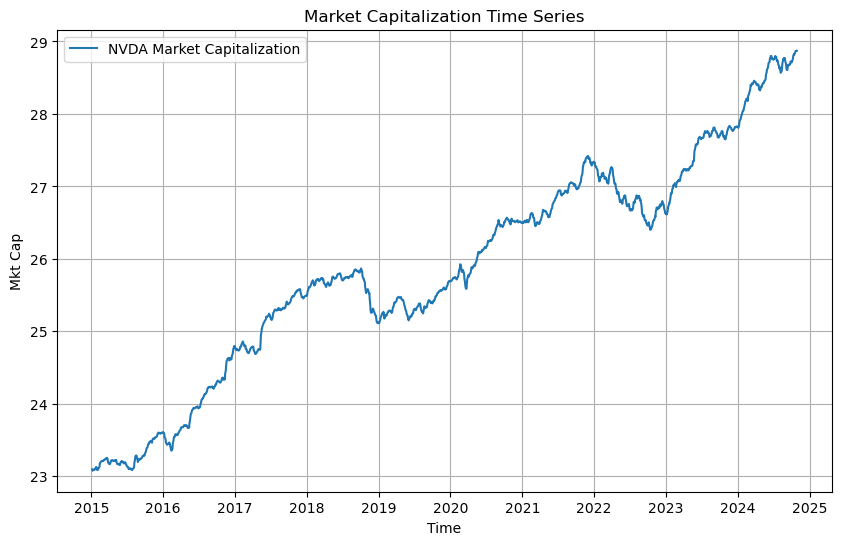

In [13]:
# Create Plot

ticker = 'NVDA'

plt.figure(figsize=(10, 6))
plt.plot(mktcap_df[ticker], label=f'{ticker} Market Capitalization', alpha=1)

# Config
plt.title('Market Capitalization Time Series')
plt.xlabel('Time')
plt.ylabel('Mkt Cap')
plt.legend()
plt.grid()

# Show
plt.show()

In [14]:
# Define the Decomposition Function
def size_decomposition(
    target_df, 
    mktcap_df
):
    # Common Indexes
    common_index = target_df.index.intersection(mktcap_df.index)
    
    # Reindex
    target_df = target_df.loc[common_index]
    mktcap_df = mktcap_df.loc[common_index]

    # Initialize lists to store portfolio returns
    big_list, mid_list, small_list = [], [], []
    
    # Get unique quarters
    quarters = sorted(set([date.to_period('Q') for date in common_index]))
    
    # Dictionary to store quarterly classifications and weights
    quarterly_classifications = {}

    for quarter in quarters:
        # Select only the last available date of the quarter
        quarter_dates = [date for date in common_index if date.to_period('Q') == quarter]
        rebalance_date = quarter_dates[-1]  # Last day of the quarter
        
        # Size factor for rebalance date
        size_factor_df = pd.DataFrame([mktcap_df.loc[rebalance_date]], index=['mkt_cap']).T.dropna()
        
        # Classify stocks into based on the median
        median = size_factor_df['mkt_cap'].median()

        size_factor_df['Size_Class'] = 'Small'
        size_factor_df.loc[size_factor_df['mkt_cap'] > median, 'Size_Class'] = 'Big'
        
        # Weights
        market_caps_df = pd.DataFrame([mktcap_df.loc[rebalance_date]], index=['mkt_cap']).T
        
        # Assign market caps to value classes
        small_mktcap_df = market_caps_df.loc[size_factor_df[size_factor_df['Size_Class'] == 'Small'].index]
        big_mktcap_df = market_caps_df.loc[size_factor_df[size_factor_df['Size_Class'] == 'Big'].index]
        
        # Compute weights
        small_weights = small_mktcap_df['mkt_cap'] / small_mktcap_df['mkt_cap'].sum()
        big_weights = big_mktcap_df['mkt_cap'] / big_mktcap_df['mkt_cap'].sum()
        
        # Store classifications and weights
        quarterly_classifications[quarter] = {
            "small": small_weights,
            "big": big_weights
        }
    
    # Iterate over all available dates to compute daily returns
    for date in common_index:
        quarter_key = date.to_period('Q')  # Get quarter of the current date
        
        if quarter_key in quarterly_classifications:
            # Retrieve stored classification and weights
            small_weights = quarterly_classifications[quarter_key]["small"]
            big_weights = quarterly_classifications[quarter_key]["big"]
            
            # Retrieve daily returns
            target = pd.DataFrame([target_df.loc[date]], index=['returns']).T
            
            small_returns = target.reindex(small_weights.index).dropna()
            big_returns = target.reindex(big_weights.index).dropna()
            
            # Compute portfolio returns
            small_result = small_weights.reindex(small_returns.index).T @ small_returns
            big_result = big_weights.reindex(big_returns.index).T @ big_returns
            
            # Store results
            small_list.append(small_result.values[0] if not small_result.empty else None)
            big_list.append(big_result.values[0] if not big_result.empty else None)

    # Create final DataFrame
    size_portfolios = pd.DataFrame({
        'big': big_list,
        'small': small_list
    }, index=common_index)
    
    return size_portfolios

In [15]:
# Create DataFrames

size_portfolio_returns = size_decomposition(returns_df, mktcap_df)

size_portfolio_returns

,big,small
Date,,
2015-01-05,-0.016180,-0.016099
2015-01-06,-0.008183,-0.010725
2015-01-07,0.012627,0.012920
2015-01-08,0.017170,0.019207
2015-01-09,-0.008344,-0.006501
...,...,...
2024-10-22,-0.002051,-0.007095
2024-10-23,-0.004097,-0.002297
2024-10-24,-0.000951,0.001554


In [16]:
# Check the Annualized Mean Returns

size_portfolio_returns.mean().mul(100).mul(252)

big      15.797560
small    13.391982
dtype: float64

In [17]:
# Check the Annualized Volatility

size_portfolio_returns.std().mul(100).mul(np.sqrt(252))

big      17.061456
small    19.791764
dtype: float64

In [18]:
# Check the Risk Adjusted Returns

size_portfolio_returns.mean().mul(100).mul(252) / size_portfolio_returns.std().mul(100).mul(np.sqrt(252))

big      0.925921
small    0.676644
dtype: float64

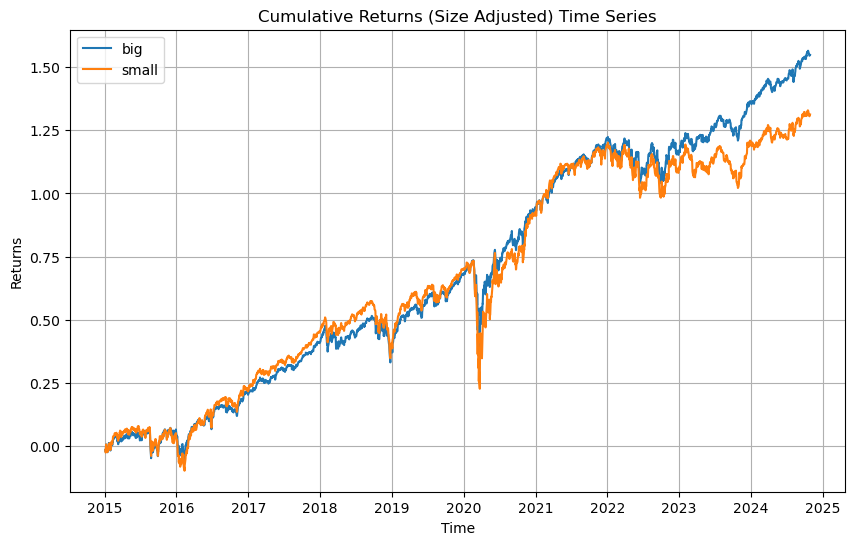

In [19]:
# Create Plot

plt.figure(figsize=(10, 6))
plt.plot(size_portfolio_returns.cumsum(), label=size_portfolio_returns.columns, alpha=1)

# Config
plt.title('Cumulative Returns (Size Adjusted) Time Series')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.grid()

# Show
plt.show()

In [20]:
# Create DataFrames

size_portfolio_betas = size_decomposition(betas_df, mktcap_df)

size_portfolio_betas

,big,small
Date,,
2016-01-08,0.956763,0.990639
2016-01-11,0.961550,0.986638
2016-01-12,0.961176,0.985804
2016-01-13,0.961208,0.983103
2016-01-14,0.962779,0.985353
...,...,...
2024-10-22,0.745925,0.740580
2024-10-23,0.745361,0.740067
2024-10-24,0.741737,0.733424


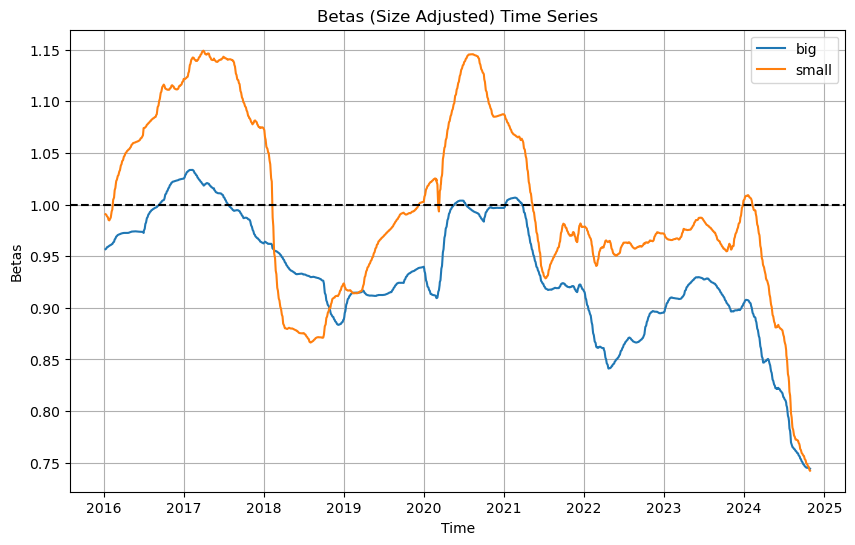

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(size_portfolio_betas.ewm(span=21, adjust = False).mean(), label=size_portfolio_betas.columns, alpha=1)
plt.axhline(y=1, color='black', linestyle='dashed')

# Config
plt.title('Betas (Size Adjusted) Time Series')
plt.xlabel('Time')
plt.ylabel('Betas')
plt.legend()
plt.grid()

# Show
plt.show()

In [22]:
# Create the data
daily_rfr = (((1 + (rfr['risk_free_rate'].div(100)))**(1/360)) - 1)
benchmark_returns = sp500['sp_500'].pct_change(1)

# Create the Excess Returns
market_excess_returns = benchmark_returns - daily_rfr

In [23]:
# Create the regression dataframe
size_regression_df = pd.DataFrame(index = size_portfolio_returns.index)

size_regression_df['big_excess_returns'] = size_portfolio_returns['big'] - daily_rfr
size_regression_df['small_excess_returns'] = size_portfolio_returns['small'] - daily_rfr
size_regression_df['market_excess_returns'] = market_excess_returns
size_regression_df.dropna(inplace = True)

size_regression_df

,big_excess_returns,small_excess_returns,market_excess_returns
Date,,,
2015-01-06,-0.008237,-0.010779,-0.008948
2015-01-07,0.012573,0.012866,0.011576
2015-01-08,0.017114,0.019151,0.017832
2015-01-09,-0.008399,-0.006555,-0.008458
2015-01-12,-0.007700,-0.006605,-0.008147
...,...,...,...
2024-10-22,-0.002165,-0.007209,-0.000589
2024-10-23,-0.004212,-0.002412,-0.009307
2024-10-24,-0.001066,0.001439,0.002031


In [24]:
# Calculate the Beta for the Large Portfolio

y = size_regression_df['big_excess_returns']

x = size_regression_df['market_excess_returns']
x = sm.add_constant(x)

# Calculate Weights
window = len(y)
weights = window * wexp(window, window/2)

#Model specification
model = sm.WLS(
    y, 
    x,
    missing='drop',
    weights=weights,
    )   
     
#the results of the model
results = model.fit() 
    
#here we check the summary
print(results.summary())

                            WLS Regression Results                            
Dep. Variable:     big_excess_returns   R-squared:                       0.953
Model:                            WLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                 4.918e+04
Date:                Wed, 09 Apr 2025   Prob (F-statistic):               0.00
Time:                        16:15:09   Log-Likelihood:                 11269.
No. Observations:                2453   AIC:                        -2.253e+04
Df Residuals:                    2451   BIC:                        -2.252e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.00

In [25]:
# Calculate the Beta for the Small Portfolio

y = size_regression_df['small_excess_returns']

x = size_regression_df['market_excess_returns']
x = sm.add_constant(x)

# Calculate Weights
window = len(y)
weights = window * wexp(window, window/2)

#Model specification
model = sm.WLS(
    y, 
    x,
    missing='drop',
    weights=weights,
    )   
     
#the results of the model
results = model.fit() 
    
#here we check the summary
print(results.summary())

                             WLS Regression Results                             
Dep. Variable:     small_excess_returns   R-squared:                       0.836
Model:                              WLS   Adj. R-squared:                  0.836
Method:                   Least Squares   F-statistic:                 1.253e+04
Date:                  Wed, 09 Apr 2025   Prob (F-statistic):               0.00
Time:                          16:15:09   Log-Likelihood:                 9369.0
No. Observations:                  2453   AIC:                        -1.873e+04
Df Residuals:                      2451   BIC:                        -1.872e+04
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const     

In [26]:
# Calculate the Small Minus Big Premium

size_regression_df['SMB'] = size_portfolio_returns['small'] - size_portfolio_returns['big']

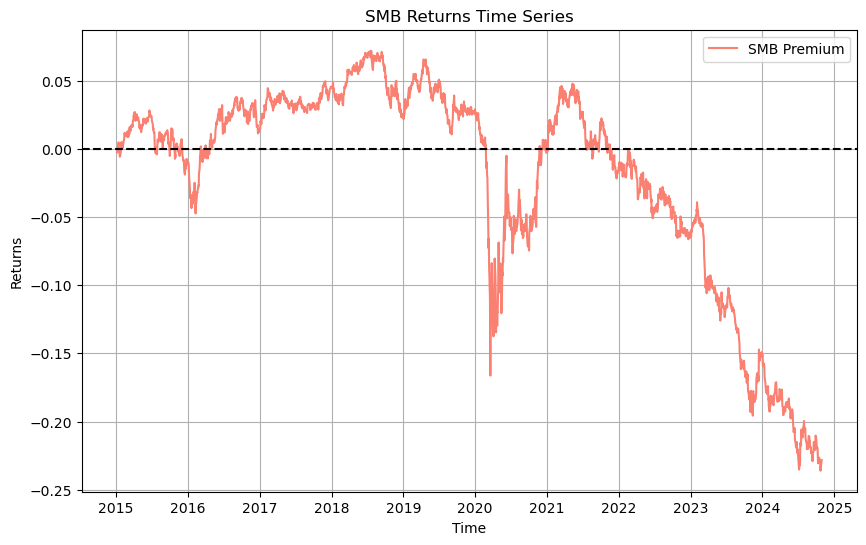

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(size_regression_df['SMB'].cumsum(), label='SMB Premium', color = 'salmon', alpha=1)
plt.axhline(y=0, color='black', linestyle='dashed')

# Config
plt.title('SMB Returns Time Series')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.grid()

# Show
plt.show()

In [28]:
# Check the Correlation with the Market

size_regression_df['SMB'].corr(size_regression_df['market_excess_returns'])

0.2532761890536437

In [29]:
# Calculate the Beta for the SMB Premium

y = size_regression_df['SMB']

x = size_regression_df['market_excess_returns']
x = sm.add_constant(x)

# Calculate Weights
window = len(y)
weights = window * wexp(window, window/2)

#Model specification
model = sm.WLS(
    y, 
    x,
    missing='drop',
    weights=weights,
    )   
     
#the results of the model
results = model.fit() 
    
#here we check the summary
print(results.summary())  

                            WLS Regression Results                            
Dep. Variable:                    SMB   R-squared:                       0.064
Model:                            WLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     167.4
Date:                Wed, 09 Apr 2025   Prob (F-statistic):           4.39e-37
Time:                        16:15:09   Log-Likelihood:                 10063.
No. Observations:                2453   AIC:                        -2.012e+04
Df Residuals:                    2451   BIC:                        -2.011e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.00

### Testing for Value Factor ###

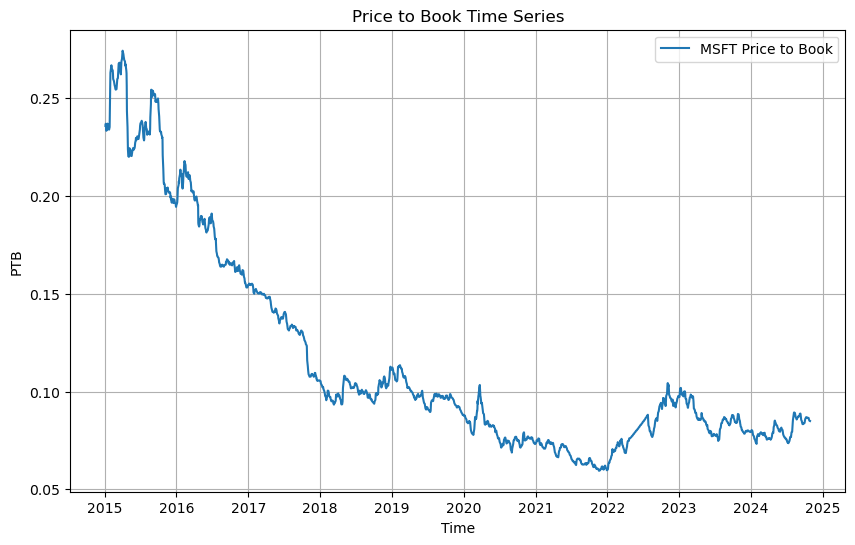

In [31]:
# Create Plot

ticker = 'MSFT'

plt.figure(figsize=(10, 6))
plt.plot(btp_df[ticker], label=f'{ticker} Price to Book', alpha=1)

# Config
plt.title('Price to Book Time Series')
plt.xlabel('Time')
plt.ylabel('PTB')
plt.legend()
plt.grid()

# Show
plt.show()

In [32]:
# Define the Decomposition Function

def value_decomposition(target_df, mktcap_df, value_df):
    # Common Indexes
    common_index = target_df.index.intersection(value_df.index).intersection(mktcap_df.index)
    
    # Reindex
    target_df = target_df.loc[common_index]
    mktcap_df = mktcap_df.loc[common_index]
    value_df = value_df.loc[common_index]

    # Initialize lists to store portfolio returns
    high_list, neutral_list, low_list = [], [], []
    
    # Get unique quarters
    quarters = sorted(set([date.to_period('Q') for date in common_index]))
    
    # Dictionary to store quarterly classifications and weights
    quarterly_classifications = {}

    for quarter in quarters:
        # Select only the last available date of the quarter
        quarter_dates = [date for date in common_index if date.to_period('Q') == quarter]
        rebalance_date = quarter_dates[-1]  # Last day of the quarter
        
        # Value factor (P/B ratio) for rebalance date
        value_factor_df = pd.DataFrame([value_df.loc[rebalance_date]], index=['btp']).T.dropna()
        
        # Classify stocks into Low, Neutral, and High based on quantiles
        lower = value_factor_df['btp'].quantile(0.3)
        upper = value_factor_df['btp'].quantile(0.7)

        value_factor_df['Value_Class'] = 'Neutral'
        value_factor_df.loc[value_factor_df['btp'] <= lower, 'Value_Class'] = 'Low'
        value_factor_df.loc[value_factor_df['btp'] >= upper, 'Value_Class'] = 'High'
        
        # Market cap data
        market_caps_df = pd.DataFrame([mktcap_df.loc[rebalance_date]], index=['mkt_cap']).T
        
        # Assign market caps to value classes
        low_mktcap_df = market_caps_df.loc[value_factor_df[value_factor_df['Value_Class'] == 'Low'].index]
        neutral_mktcap_df = market_caps_df.loc[value_factor_df[value_factor_df['Value_Class'] == 'Neutral'].index]
        high_mktcap_df = market_caps_df.loc[value_factor_df[value_factor_df['Value_Class'] == 'High'].index]
        
        # Compute weights
        low_weights = low_mktcap_df['mkt_cap'] / low_mktcap_df['mkt_cap'].sum()
        neutral_weights = neutral_mktcap_df['mkt_cap'] / neutral_mktcap_df['mkt_cap'].sum()
        high_weights = high_mktcap_df['mkt_cap'] / high_mktcap_df['mkt_cap'].sum()
        
        # Store classifications and weights
        quarterly_classifications[quarter] = {
            "low": low_weights,
            "neutral": neutral_weights,
            "high": high_weights
        }
    
    # Iterate over all available dates to compute daily returns
    for date in common_index:
        quarter_key = date.to_period('Q')  # Get quarter of the current date
        
        if quarter_key in quarterly_classifications:
            # Retrieve stored classification and weights
            low_weights = quarterly_classifications[quarter_key]["low"]
            neutral_weights = quarterly_classifications[quarter_key]["neutral"]
            high_weights = quarterly_classifications[quarter_key]["high"]
            
            # Retrieve daily returns
            target = pd.DataFrame([target_df.loc[date]], index=['returns']).T
            
            low_returns = target.reindex(low_weights.index).dropna()
            neutral_returns = target.reindex(neutral_weights.index).dropna()
            high_returns = target.reindex(high_weights.index).dropna()
            
            # Compute portfolio returns
            low_result = low_weights.reindex(low_returns.index).T @ low_returns
            neutral_result = neutral_weights.reindex(neutral_returns.index).T @ neutral_returns
            high_result = high_weights.reindex(high_returns.index).T @ high_returns
            
            # Store results
            low_list.append(low_result.values[0] if not low_result.empty else None)
            neutral_list.append(neutral_result.values[0] if not neutral_result.empty else None)
            high_list.append(high_result.values[0] if not high_result.empty else None)

    # Create final DataFrame
    value_portfolios = pd.DataFrame({
        'high': high_list,
        'neutral': neutral_list,
        'low': low_list
    }, index=common_index)
    
    return value_portfolios

In [33]:
# Create DataFrames

value_portfolio_returns = value_decomposition(returns_df, mktcap_df, btp_df)

value_portfolio_returns

,high,neutral,low
Date,,,
2015-01-05,-0.019717,-0.016164,-0.012546
2015-01-06,-0.009913,-0.009371,-0.008958
2015-01-07,0.011289,0.012152,0.015065
2015-01-08,0.016340,0.019039,0.018779
2015-01-09,-0.008284,-0.007111,-0.007086
...,...,...,...
2024-10-22,-0.002333,-0.005424,-0.005356
2024-10-23,-0.000748,-0.002565,-0.006478
2024-10-24,-0.002638,0.000641,0.002561


In [34]:
# Check the Annualized Mean Returns

value_portfolio_returns.mean().mul(100).mul(252)

high        6.176075
neutral    14.426171
low        23.186467
dtype: float64

In [35]:
# Check the Annualized Volatility

value_portfolio_returns.std().mul(100).mul(np.sqrt(252))

high       21.179727
neutral    17.485601
low        18.183496
dtype: float64

In [36]:
# Check the Risk Adjusted Returns

value_portfolio_returns.mean().mul(100).mul(252) / value_portfolio_returns.std().mul(100).mul(np.sqrt(252))

high       0.291603
neutral    0.825031
low        1.275138
dtype: float64

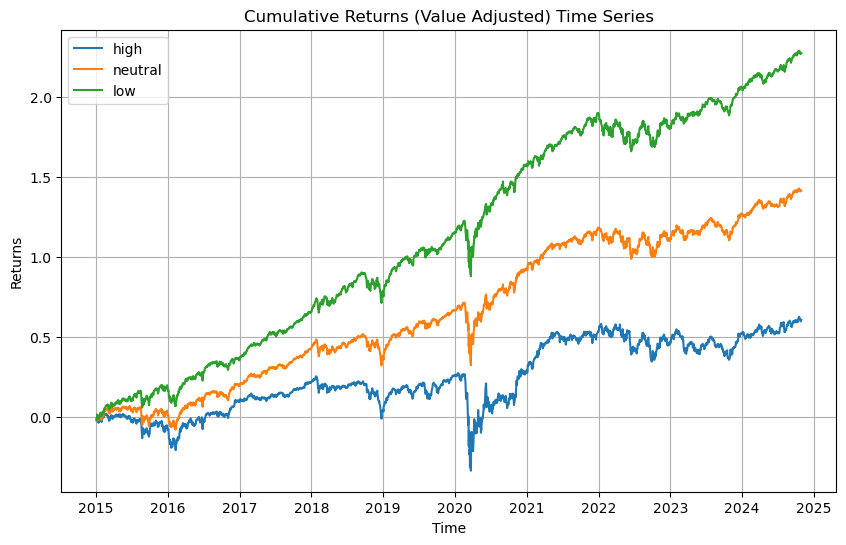

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(value_portfolio_returns.cumsum(), label=value_portfolio_returns.columns, alpha=1)

# Config
plt.title('Cumulative Returns (Value Adjusted) Time Series')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.grid()

# Show
plt.show()

In [38]:
# Create DataFrames

value_portfolio_betas = value_decomposition(betas_df, mktcap_df, ptb_df)

value_portfolio_betas

,high,neutral,low
Date,,,
2016-01-08,0.936587,0.960911,1.026109
2016-01-11,0.945217,0.960906,1.019275
2016-01-12,0.944394,0.960145,1.019129
2016-01-13,0.944084,0.960508,1.014654
2016-01-14,0.948071,0.961613,1.015517
...,...,...,...
2024-10-22,0.870985,0.710191,0.655936
2024-10-23,0.871576,0.709519,0.654408
2024-10-24,0.869021,0.702790,0.648914


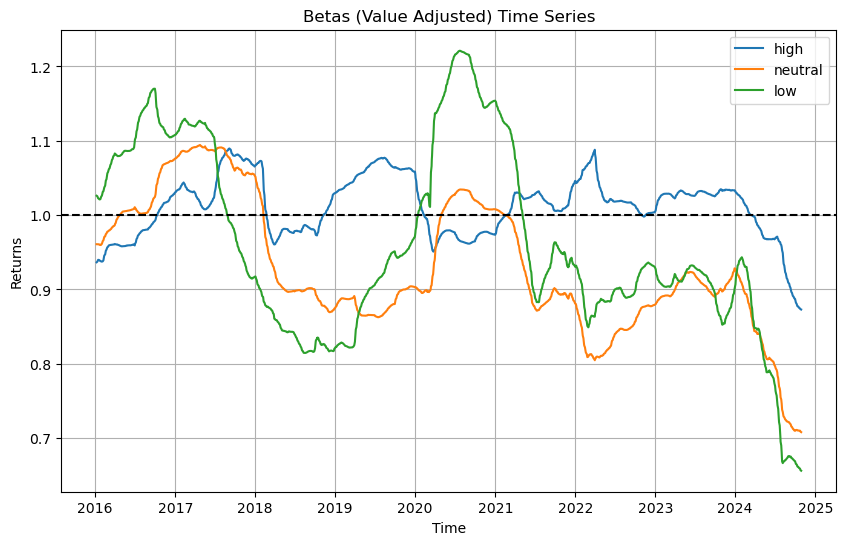

In [39]:
plt.figure(figsize=(10, 6))
plt.plot(value_portfolio_betas.ewm(span=21, adjust = False).mean(), label=value_portfolio_betas.columns, alpha=1)
plt.axhline(y=1, color='black', linestyle='dashed')

# Config
plt.title('Betas (Value Adjusted) Time Series')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.grid()

# Show
plt.show()

In [40]:
# Create the data
daily_rfr = (((1 + (rfr['risk_free_rate'].div(100)))**(1/360)) - 1)
benchmark_returns = sp500['sp_500'].pct_change(1)

# Create the Excess Returns
market_excess_returns = benchmark_returns - daily_rfr

In [41]:
# Create the regression dataframe
value_regression_df = pd.DataFrame(index = value_portfolio_returns.index)

value_regression_df['high_excess_returns'] = value_portfolio_returns['high'] - daily_rfr
value_regression_df['neutral_excess_returns'] = value_portfolio_returns['neutral'] - daily_rfr
value_regression_df['low_excess_returns'] = value_portfolio_returns['low'] - daily_rfr
value_regression_df['market_excess_returns'] = market_excess_returns
value_regression_df.dropna(inplace = True)

value_regression_df

,high_excess_returns,neutral_excess_returns,low_excess_returns,market_excess_returns
Date,,,,
2015-01-06,-0.009968,-0.009426,-0.009012,-0.008948
2015-01-07,0.011235,0.012098,0.015012,0.011576
2015-01-08,0.016284,0.018983,0.018724,0.017832
2015-01-09,-0.008338,-0.007165,-0.007141,-0.008458
2015-01-12,-0.009523,-0.006196,-0.006129,-0.008147
...,...,...,...,...
2024-10-22,-0.002448,-0.005539,-0.005471,-0.000589
2024-10-23,-0.000864,-0.002680,-0.006593,-0.009307
2024-10-24,-0.002752,0.000527,0.002446,0.002031


In [42]:
# Calculate the Beta for the High Portfolio

y = value_regression_df['high_excess_returns']

x = value_regression_df['market_excess_returns']
x = sm.add_constant(x)

# Calculate Weights
window = len(y)
weights = window * wexp(window, window/2)

#Model specification
model = sm.WLS(
    y, 
    x,
    missing='drop',
    weights=weights,
    )   
     
#the results of the model
results = model.fit() 
    
#here we check the summary
print(results.summary())

                             WLS Regression Results                            
Dep. Variable:     high_excess_returns   R-squared:                       0.722
Model:                             WLS   Adj. R-squared:                  0.722
Method:                  Least Squares   F-statistic:                     6358.
Date:                 Wed, 09 Apr 2025   Prob (F-statistic):               0.00
Time:                         16:15:39   Log-Likelihood:                 8558.8
No. Observations:                 2453   AIC:                        -1.711e+04
Df Residuals:                     2451   BIC:                        -1.710e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const               

In [43]:
# Calculate the Beta for the Neutral Portfolio

y = value_regression_df['neutral_excess_returns']

x = value_regression_df['market_excess_returns']
x = sm.add_constant(x)

# Calculate Weights
window = len(y)
weights = window * wexp(window, window/2)

#Model specification
model = sm.WLS(
    y, 
    x,
    missing='drop',
    weights=weights,
    )   
     
#the results of the model
results = model.fit() 
    
#here we check the summary
print(results.summary()) 

                              WLS Regression Results                              
Dep. Variable:     neutral_excess_returns   R-squared:                       0.908
Model:                                WLS   Adj. R-squared:                  0.908
Method:                     Least Squares   F-statistic:                 2.421e+04
Date:                    Wed, 09 Apr 2025   Prob (F-statistic):               0.00
Time:                            16:15:39   Log-Likelihood:                 10387.
No. Observations:                    2453   AIC:                        -2.077e+04
Df Residuals:                        2451   BIC:                        -2.076e+04
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

In [44]:
# Calculate the Beta for the Low Portfolio

y = value_regression_df['low_excess_returns']

x = value_regression_df['market_excess_returns']
x = sm.add_constant(x)

# Calculate Weights
window = len(y)
weights = window * wexp(window, window/2)

#Model specification
model = sm.WLS(
    y, 
    x,
    missing='drop',
    weights=weights,
    )   
     
#the results of the model
results = model.fit() 
    
#here we check the summary
print(results.summary())  

                            WLS Regression Results                            
Dep. Variable:     low_excess_returns   R-squared:                       0.935
Model:                            WLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                 3.537e+04
Date:                Wed, 09 Apr 2025   Prob (F-statistic):               0.00
Time:                        16:15:39   Log-Likelihood:                 10716.
No. Observations:                2453   AIC:                        -2.143e+04
Df Residuals:                    2451   BIC:                        -2.142e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.00

In [45]:
# Calculate the Small Minus Big Premium

value_regression_df['HML'] = value_regression_df['high_excess_returns'] - value_regression_df['low_excess_returns']

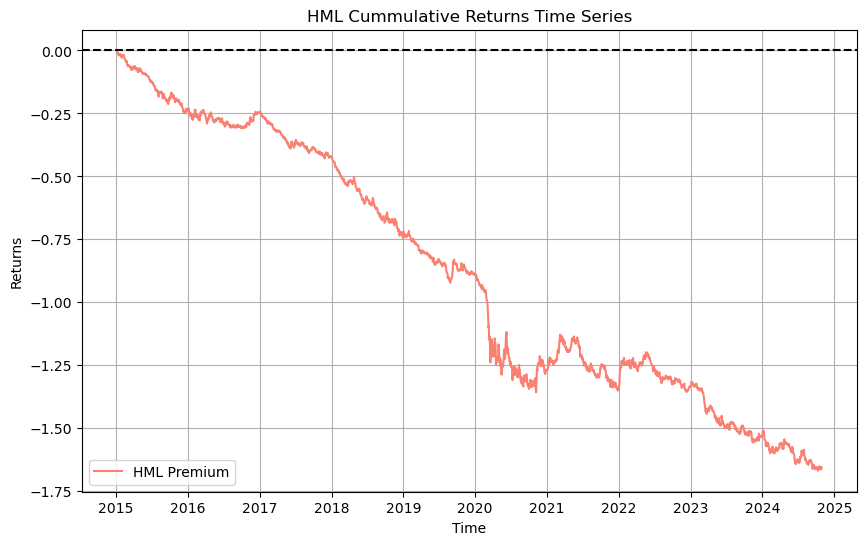

In [46]:
plt.figure(figsize=(10, 6))
plt.plot(value_regression_df['HML'].cumsum(), label='HML Premium', color = 'salmon', alpha=1)
plt.axhline(y=0, color='black', linestyle='dashed')

# Config
plt.title('HML Cummulative Returns Time Series')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.grid()

# Show
plt.show()

In [47]:
# Check the Correlation with the Market

value_regression_df['HML'].corr(value_regression_df['market_excess_returns'])

0.06206335627281251

In [48]:
# Calculate the Beta for the HML Premium

y = value_regression_df['HML']

x = value_regression_df['market_excess_returns']
x = sm.add_constant(x)

# Calculate Weights
window = len(y)
weights = window * wexp(window, window/2)

#Model specification
model = sm.WLS(
    y, 
    x,
    missing='drop',
    weights=weights,
    )   
     
#the results of the model
results = model.fit() 
    
#here we check the summary
print(results.summary())  

                            WLS Regression Results                            
Dep. Variable:                    HML   R-squared:                       0.001
Model:                            WLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.427
Date:                Wed, 09 Apr 2025   Prob (F-statistic):              0.119
Time:                        16:15:39   Log-Likelihood:                 8353.1
No. Observations:                2453   AIC:                        -1.670e+04
Df Residuals:                    2451   BIC:                        -1.669e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.00

### Collinearity among factors ###

In [50]:
value_regression_df['HML'].corr(size_regression_df['SMB'])

0.5877448662241904

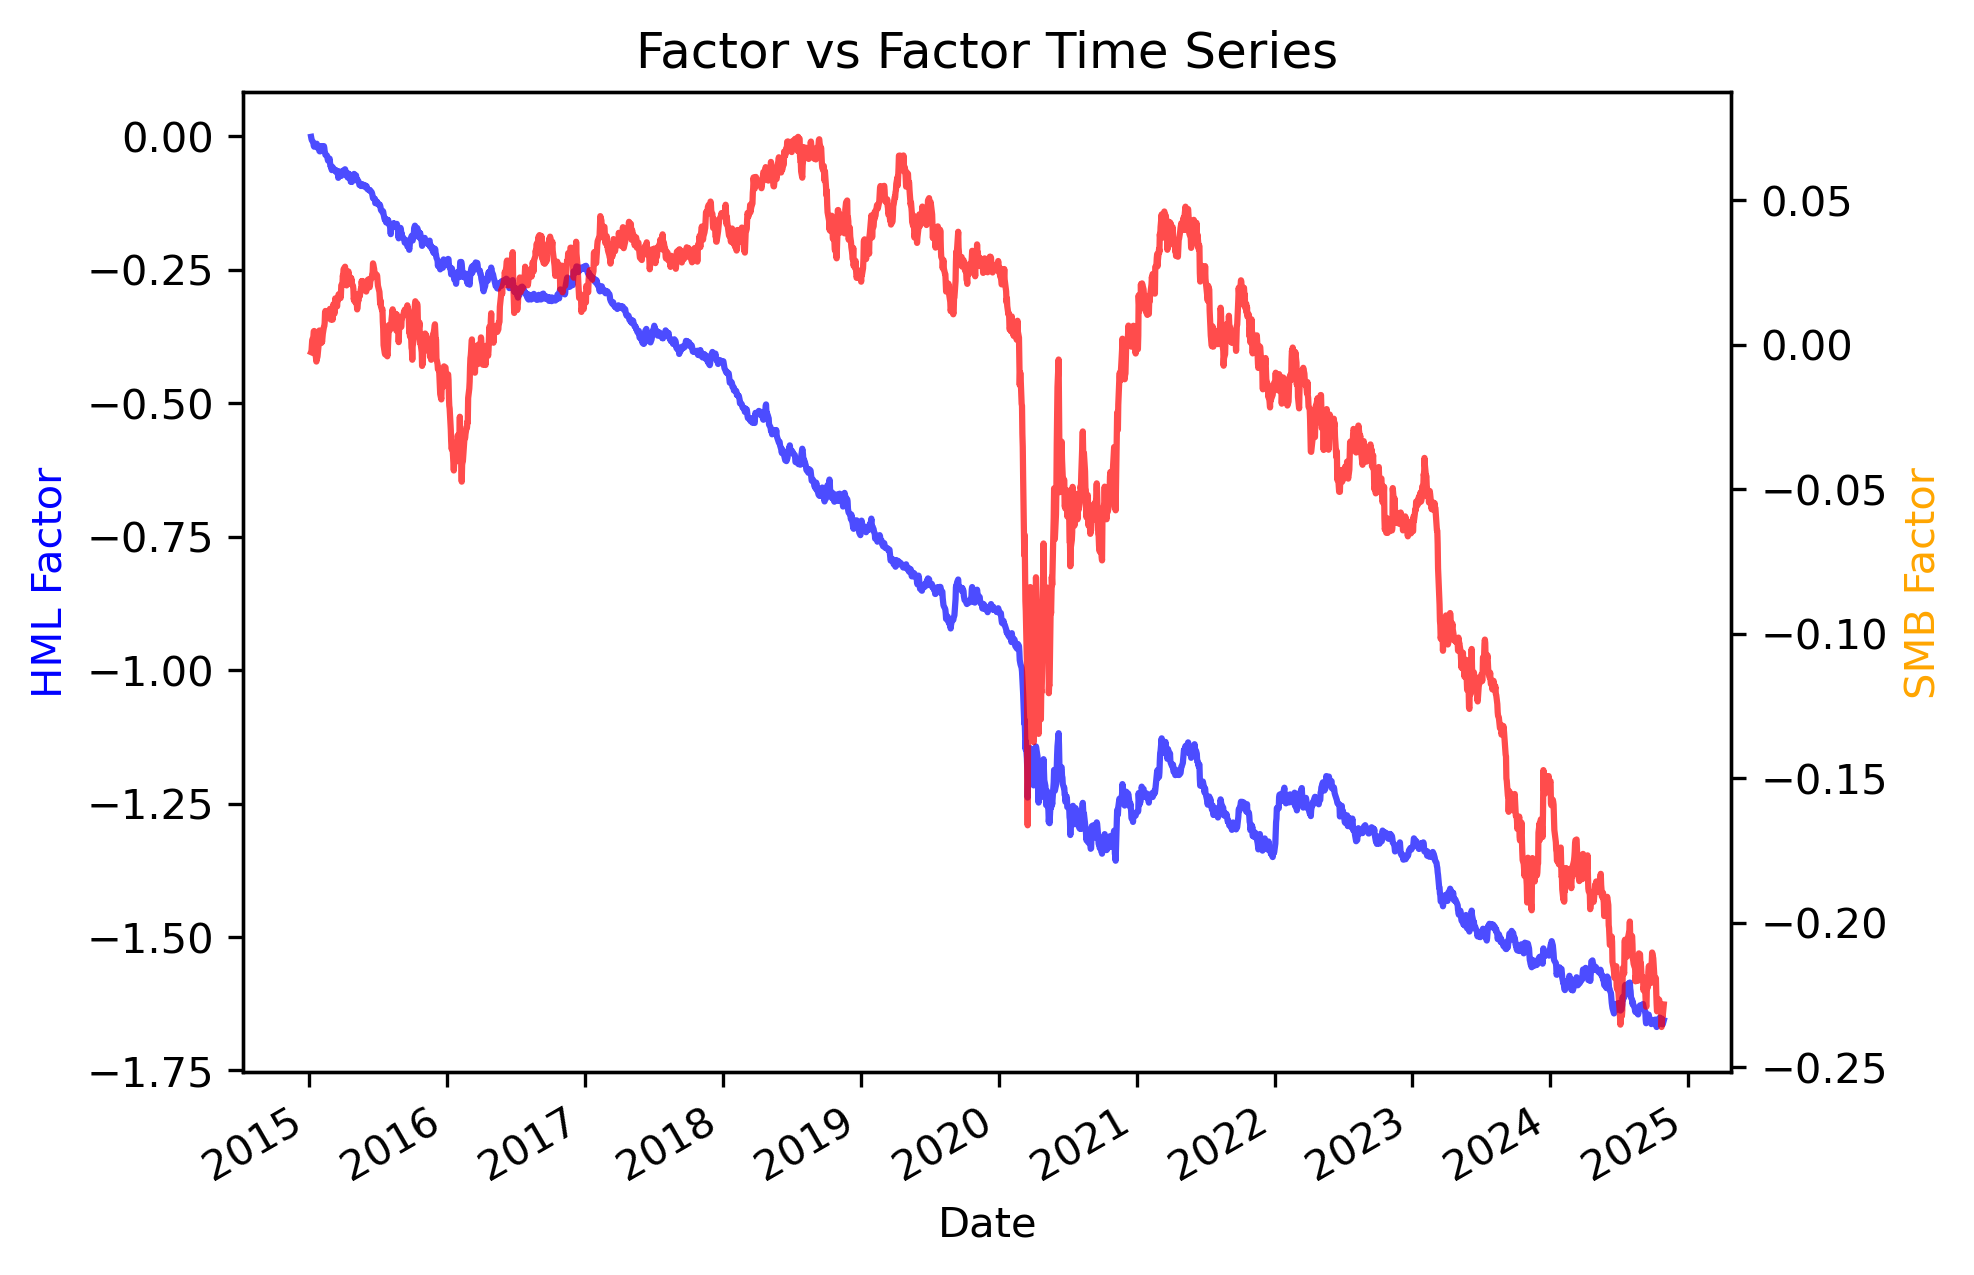

In [51]:
# Create Figure
fig, ax1 = plt.subplots(dpi = 300)

# Market Returns Plot
value_regression_df['HML'].cumsum().plot(color = 'blue', ax = ax1, alpha=0.7)
ax1.set_xlabel('Date')
ax1.set_ylabel(
    'HML Factor', 
    color='blue'
    )

# ZBP Returns Plot
ax2 = ax1.twinx()

size_regression_df['SMB'].cumsum().plot(color = 'red', ax = ax2, alpha=0.7)
ax2.set_ylabel(
    'SMB Factor', 
    color='orange'
    )

plt.title('Factor vs Factor Time Series')
plt.show()